In [1]:
%matplotlib agg
%matplotlib agg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scipy.stats as st
import importlib
import os
import sys
import platform
import qgrid
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import pickle
import random

from numba import njit

from sync_class import SyncPhenosys
from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport


%load_ext autoreload
%autoreload 2

#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)


#plt.style.use('ggplot')
#plt.style.use('gadfly.mplstyle')

%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')




# ================================================================================================
# specify file path & sessions

windows_folder = r"C:/Users/User/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
linux_folder = "/home/max/ExpanDrive/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
mac_folder = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"

# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[(0,1),(259,'end')]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[(0,1),(276,'end')]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[(271,'end')]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[(184,'end')]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[(307,'end')]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[(0,0),(204,'end')]),
         ]



def load_session(session, missing_rows_ttl=[], lo_spikes=False, deselect_trials=[]):
    # load calss and set folder depending on platform
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/' + session
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/" + session
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/" + session
        
    sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
    behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
    if lo_spikes:
        print(f"{session} -> spikes")
        eda_obj = SpikesEDA(behavior_obj)
        sda_obj = SpikesSDA(eda_obj)
        report_obj = SpikesReport(sda_obj)
        session_obj = type('obj', (object,), 
                       {'sync':sync_obj,
                        'behavior':behavior_obj,
                        'eda':eda_obj,
                        'sda': sda_obj,
                        'report': report_obj,
                       })
    else:
        print(f"{session} -> eda")
        session_obj = type('obj', (object,), 
               {'sync':sync_obj,
                'behavior':behavior_obj,
               })


    return session_obj

# ==========================================================================================
# save & load sessions from pickl functions

# save dict to pickl
def save_all_sessions_dict_pickl(all_sessions_dict):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
    
    for key,value in all_sessions_dict.items():
        file = folder + f"/{key}.pkl"
        with open(file, 'wb') as dump:
            pickle.dump(value, dump, pickle.HIGHEST_PROTOCOL)
            

# load dict from pickl
def load_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    with open(file, 'rb') as dump:
        all_sessions_dict = pickle.load(dump)
    return all_sessions_dict



# =======================================================================================
# save figures
def save_fig(name, fig):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder+"/figures/all_figures"
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder+"\figures\all_figures"
    elif platform.system() == 'Darwin':
        folder = mac_folder+"/figures/all_figures"
    try:
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')
    except:
        if platform.system() == 'Linux':
            # Linux
            folder = linux_folder+"/figures"
        elif platform.system() == 'Windows':
            # windows
            folder = windows_folder+"\figures"
        elif platform.system() == 'Darwin':
            folder = mac_folder+"/figures"
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')

      
    
# =======================================================================================
@njit(fastmath=True)
# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        for it in range(iterations):
            data_ar[cl,:,it]=(np.histogram(np.concatenate(input_ar[cl,:,it]).ravel(),bins=nr_bins))[0]
    return data_ar




# =======================================================================================
@njit(fastmath=True)
# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        for it in range(iterations):
            data_ar[cl,:,it]=(np.histogram(np.concatenate(input_ar[cl,:,it]).ravel(),bins=nr_bins))[0]
    return data_ar




**Load All Sessions**

In [159]:
# load alls session

all_sessions_dict = dict()
# load all sessions into dict
for session_name,missing_rows_ttl,load_spikes,spikes_trials_skip in se_li:
    all_sessions_dict[session_name]=load_session(session_name, missing_rows_ttl, load_spikes, spikes_trials_skip)


ValueError: Length mismatch: Expected axis has 2172 elements, new values have 2621 elements

---

# All Sessions Analyze

In [ ]:
def convert_numeric(columns, df):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df

def get_trial_info(all_sessions_dict):
    session_info_df = pd.DataFrame(columns=['id','blocks','tot. trials','wheel ns trials','no resp trials','selected trials',
                                           'reward','no-reward','gamble', 'safe',
                                           'gamble rewarded','safe reward','gamble no-reward','safe no-reward',
                                           ],
                                  )
    # get individual session objects
    for key,value in all_sessions_dict.items():
        session_name=key
        gamble_side=value.behavior.gamble_side
        missing_rows_ttl=value.sync.rows_missing_ttl
        combined=value.sync.combined_df
        trials=value.sync.all_trials_df
        
        # get info of combined_df
        prop_bin=list((combined['CSV Probability']).dropna().unique())
        # get info form combined
        all_trials = int(combined.index.get_level_values(0).max())
        good_trials = int(combined.index.get_level_values(1).max())
        wheel_ns_trials = all_trials - good_trials
        no_resp_trials = (combined['CSV Event']=='no response in time').sum(axis=0)
        selected_trials = value.behavior.selected_trials_df.shape[0]
        
        rw=(value.behavior.selected_trials_df["reward_given"]==True).sum()
        norw=(value.behavior.selected_trials_df["reward_given"]==False).sum()
        
        right = (value.behavior.selected_trials_df["right"]==True).sum()
        right_rw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["right"])&(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        right_norw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["right"])&np.invert(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        left = (value.behavior.selected_trials_df["left"]==True).sum()
        left_rw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["left"])&(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        left_norw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["left"])&np.invert(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        
        # set safe and gamble side
        if gamble_side=="right":
            gamble=right
            gamble_rw=right_rw
            gamble_norw=right_norw
            safe=left
            safe_rw=left_rw
            safe_norw=left_norw
        elif gamble_side=="left":
            gamble=left
            gamble_rw=left_rw
            gamble_norw=left_norw
            save=right
            save_rw=right_rw    
            save_norw=right_norw

        session_info_df.loc[session_info_df.shape[0] + 1] = [session_name,
                                                             prop_bin,
                                                             all_trials,
                                                             wheel_ns_trials,
                                                             no_resp_trials,
                                                             selected_trials,
                                                             rw,
                                                             norw,
                                                             gamble,
                                                             safe,
                                                             gamble_rw,
                                                             safe_rw,
                                                             gamble_norw,
                                                             safe_norw
                                                             ]
        
        session_info_df = convert_numeric(['tot. trials','wheel ns trials','no resp trials','selected trials',
                                           'reward','no-reward','gamble', 'safe',
                                           'gamble rewarded','safe reward', 'gamble no-reward', 'safe no-reward'],
                       session_info_df)
        
    return session_info_df


def boxplot(df,columns,scatter=True,title=None):
    fig,ax = plt.subplots()
    session_info_df.boxplot(column=columns,return_type='axes',ax=ax)
    
    if scatter:
        i = 1
        for column in columns:
            y=session_info_df[column] 
            x=np.ones(y.shape[0])*i
            ax.plot(x, y, 'r.', alpha=0.5)
            i+=1
        ax.plot(x,y,'r.',alpha=0.5,label="session")
    ax.set_ylabel('Trial')
    ax.set_title(title)
    ax.legend()

    return fig,ax

In [ ]:
session_info_df=get_trial_info(all_sessions_dict)
session_info_df

In [ ]:
print(session_info_df.to_latex(index=False)) 

In [ ]:
# wheel not stop vs other
fig,ax = boxplot(session_info_df,['tot. trials','wheel ns trials','no resp trials','selected trials' ],True)
save_fig("boxplot_whell_ns", fig)

# gamble vs save
fig,ax = boxplot(session_info_df,['no resp trials','gamble','safe'],True)
save_fig("boxplot_gamble_safe", fig)

# reward vs no-reward

fig,ax = boxplot(session_info_df,['reward','no-reward'],True)
save_fig("boxplot_rw_norw", fig)

# Single Session Analyze

## Pipeline Example

In [ ]:
session = 'NAME'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = []
# behavior
deselect_trials = [(X,X),(X,'end')]
# sda
window = 2000
iterations = 1000
bins = 50

#sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
#behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)

"""
NAME = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

In [ ]:
%%time
%matplotlib agg
NAME.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
NAME.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
NAME.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
NAME.report.generate_report()

In [11]:
del JG14_190621

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [ ]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [ ]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

In [ ]:
csv = sync_obj.csv
qgrid.show_grid(csv)

In [ ]:
# first find missing rows
missing_rows = ()
combined = sync_obj.combine_dataframes(missing_rows, additonal_rows, 'channel 1', csv)

qgrid.show_grid(combined)

---

**Overview**

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
combined['Delta (TTL-CSV)'].plot()

In [ ]:
combined.iloc[1720:1730]

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [ ]:
NAME.eda.plt_trial_length()

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
NAME.eda.trials_df.loc[0:1, 'select'] = False
# end
NAME.eda.trials_df.loc[215:, 'select'] = False
NAME.eda.trials_df

In [ ]:
NAME.eda.plt_trial_hist_and_fit(
    NAME.eda.trials_df.loc[NAME.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG14_190619

In [10]:
session = 'JG14_190619'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = [111,2780]
# behavior
deselect_trials = []#(X,X),(X,'end')
# sda
window = 2000
iterations = 1000
bins = 50

sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)
"""
JG14_190619 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

"\nJG14_190619 = type('obj', (object,), \n                   {'sync':sync_obj,\n                    'behavior':behavior_obj,\n                    'eda':eda_obj,\n                    'sda': sda_obj,\n                    'report': report_obj,\n                   })\n"

In [ ]:
%%time
%matplotlib agg
JG14_190619.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
JG14_190619.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
JG14_190619.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG14_190619.report.generate_report()

In [11]:
del JG14_190619

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [11]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [12]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [13]:
csv = sync_obj.csv
qgrid.show_grid(csv)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [31]:
# first find missing rows
rows_missing_ttl = [111,2780]
combined = sync_obj.combine_dataframes(align=True,rows_missing_ttl=False)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

**Overview**

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


In [26]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

In [22]:
combined.iloc[1720:1730]

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
565.0     NaN   1720  0            11318457.0        19.0     start   
                1721  1                   NaN         NaN       NaN   
566.0     NaN   1722  0            11326260.0        20.0     start   
                1723  1                   NaN         NaN       NaN   
567.0     118.0 1724  0            11346318.0        40.0       cue   
                1725  1            11346958.0        60.0     sound   
                1726  2            11347638.0        81.0  openloop   
                1727  3            11355442.0       137.0   left_rw   
                1728  4            11359219.0       200.0       iti   
                1729  5            11379420.0       220.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
565.0     NaN   1720  0                10959105.0     1273.0  10970960.0   
                1721  1                       NaN        NaN  10972860.0   
566.0     NaN   1722  0                10966908.0     1274.0  10975880.0   
                1723  1                       NaN        NaN  10980660.0   
567.0     118.0 1724  0                10986966.0     1275.0  10983680.0   
                1725  1                10987606.0     1276.0  11003740.0   
                1726  2                10988286.0     1277.0  11004380.0   
                1727  3                10996090.0     1278.0  11005060.0   
                1728  4                10999867.0     1279.0  11012860.0   
                1729  5                11020068.0     1280.0  11016640.0   

                                            CSV Event CSV Probability  \
All Trial Trial index Group Index                                       
565.0     NaN   1720  0                         start            0.25   
                1721  1            wheel not stopping             NaN   
566.0     NaN   1722  0                         start            0.25   
                1723  1            wheel not stopping             NaN   
567.0     118.0 1724  0                         start            0.25   
                1725  1                           cue            0.25   
                1726  2                         sound            0.25   
                1727  3                      openloop            0.25   
                1728  4                       left_rw            0.25   
                1729  5                           iti            0.25   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
565.0     NaN   1720  0                10954001.0     1273.0           5104.0   
                1721  1                10955901.0        NaN              NaN   
566.0     NaN   1722  0                10958921.0     1274.0           7987.0   
                1723  1                10963701.0        NaN              NaN   
567.0     118.0 1724  0                10966721.0     1275.0          20245.0   
                1725  1                10986781.0     1276.0            825.0   
                1726  2                10987421.0     1277.0            865.0   
                1727  3                10988101.0     1278.0           7989.0   
                1728  4                10995901.0     1279.0           3966.0   
                1729  5                10999681.0     1280.0          20387.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
565.0     NaN   1720  0              True      False  
                1721  1               NaN      False  
566.0     NaN   1722  0              True      False  
                1723  1               NaN      False  
567.0     118.0 1724  0             False       True  
                1725  1            

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [58]:
deselect_trials = [(0,1),(259,'end')]
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)

In [59]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.selected_trials_df)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
JG14_190619.behavior.seleted_trials_df.loc[0:1, 'select'] = False
# end
JG14_190619.behavior.selected_trials_df.loc[215:, 'select'] = False
JG14_190619.behavior.selected_trials_df

In [ ]:
JG14_190619.eda.plt_trial_hist_and_fit(
    JG14_190619.eda.trials_df.loc[JG14_190619.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG14_190626

In [93]:
session = 'JG14_190626'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl =  [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443]
# behavior
deselect_trials = []#(X,X),(X,'end')
# sda
window = 2000
iterations = 1000
bins = 50

#sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
#behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)
"""
JG14_190619 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

"\nJG14_190619 = type('obj', (object,), \n                   {'sync':sync_obj,\n                    'behavior':behavior_obj,\n                    'eda':eda_obj,\n                    'sda': sda_obj,\n                    'report': report_obj,\n                   })\n"

In [ ]:
%%time
%matplotlib agg
JG14_190626.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
JG14_190626.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
JG14_190626.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG14_190626.report.generate_report()

In [11]:
del JG14_190626

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [94]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [68]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [69]:
csv = sync_obj.csv
qgrid.show_grid(csv)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [70]:
# first find missing rows
combined = sync_obj.combine_dataframes(align=True,rows_missing_ttl=rows_missing_ttl)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

**Overview**

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


In [26]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

In [22]:
combined.iloc[1720:1730]

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
565.0     NaN   1720  0            11318457.0        19.0     start   
                1721  1                   NaN         NaN       NaN   
566.0     NaN   1722  0            11326260.0        20.0     start   
                1723  1                   NaN         NaN       NaN   
567.0     118.0 1724  0            11346318.0        40.0       cue   
                1725  1            11346958.0        60.0     sound   
                1726  2            11347638.0        81.0  openloop   
                1727  3            11355442.0       137.0   left_rw   
                1728  4            11359219.0       200.0       iti   
                1729  5            11379420.0       220.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
565.0     NaN   1720  0                10959105.0     1273.0  10970960.0   
                1721  1                       NaN        NaN  10972860.0   
566.0     NaN   1722  0                10966908.0     1274.0  10975880.0   
                1723  1                       NaN        NaN  10980660.0   
567.0     118.0 1724  0                10986966.0     1275.0  10983680.0   
                1725  1                10987606.0     1276.0  11003740.0   
                1726  2                10988286.0     1277.0  11004380.0   
                1727  3                10996090.0     1278.0  11005060.0   
                1728  4                10999867.0     1279.0  11012860.0   
                1729  5                11020068.0     1280.0  11016640.0   

                                            CSV Event CSV Probability  \
All Trial Trial index Group Index                                       
565.0     NaN   1720  0                         start            0.25   
                1721  1            wheel not stopping             NaN   
566.0     NaN   1722  0                         start            0.25   
                1723  1            wheel not stopping             NaN   
567.0     118.0 1724  0                         start            0.25   
                1725  1                           cue            0.25   
                1726  2                         sound            0.25   
                1727  3                      openloop            0.25   
                1728  4                       left_rw            0.25   
                1729  5                           iti            0.25   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
565.0     NaN   1720  0                10954001.0     1273.0           5104.0   
                1721  1                10955901.0        NaN              NaN   
566.0     NaN   1722  0                10958921.0     1274.0           7987.0   
                1723  1                10963701.0        NaN              NaN   
567.0     118.0 1724  0                10966721.0     1275.0          20245.0   
                1725  1                10986781.0     1276.0            825.0   
                1726  2                10987421.0     1277.0            865.0   
                1727  3                10988101.0     1278.0           7989.0   
                1728  4                10995901.0     1279.0           3966.0   
                1729  5                10999681.0     1280.0          20387.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
565.0     NaN   1720  0              True      False  
                1721  1               NaN      False  
566.0     NaN   1722  0              True      False  
                1723  1               NaN      False  
567.0     118.0 1724  0             False       True  
                1725  1            

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [113]:
deselect_trials = [(0,1),(276,'end')]
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)



In [116]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.selected_trials_df)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
JG14_190626.behavior.seleted_trials_df.loc[0:1, 'select'] = False
# end
JG14_190626.behavior.selected_trials_df.loc[215:, 'select'] = False
JG14_190626.behavior.selected_trials_df

In [ ]:
JG14_190626.eda.plt_trial_hist_and_fit(
    JG14_190626.eda.trials_df.loc[JG14_190619.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG15_190722

In [160]:
session = 'JG15_190722'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl =  [2094, 2574, 2637, 2808, 2831, 3499]
# behavior
deselect_trials = []#(X,X),(X,'end')
# sda
window = 2000
iterations = 1000
bins = 50

#sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
#behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)
"""
JG14_190619 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

"\nJG14_190619 = type('obj', (object,), \n                   {'sync':sync_obj,\n                    'behavior':behavior_obj,\n                    'eda':eda_obj,\n                    'sda': sda_obj,\n                    'report': report_obj,\n                   })\n"

In [ ]:
%%time
%matplotlib agg
JG15_190722.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
JG15_190722.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
JG15_190722.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG15_190722.report.generate_report()

In [11]:
del JG15_190722

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [161]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [68]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [69]:
csv = sync_obj.csv
qgrid.show_grid(csv)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [70]:
# first find missing rows
combined = sync_obj.combine_dataframes(align=True,rows_missing_ttl=rows_missing_ttl)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

**Overview**

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


In [26]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

In [22]:
combined.iloc[1720:1730]

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
565.0     NaN   1720  0            11318457.0        19.0     start   
                1721  1                   NaN         NaN       NaN   
566.0     NaN   1722  0            11326260.0        20.0     start   
                1723  1                   NaN         NaN       NaN   
567.0     118.0 1724  0            11346318.0        40.0       cue   
                1725  1            11346958.0        60.0     sound   
                1726  2            11347638.0        81.0  openloop   
                1727  3            11355442.0       137.0   left_rw   
                1728  4            11359219.0       200.0       iti   
                1729  5            11379420.0       220.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
565.0     NaN   1720  0                10959105.0     1273.0  10970960.0   
                1721  1                       NaN        NaN  10972860.0   
566.0     NaN   1722  0                10966908.0     1274.0  10975880.0   
                1723  1                       NaN        NaN  10980660.0   
567.0     118.0 1724  0                10986966.0     1275.0  10983680.0   
                1725  1                10987606.0     1276.0  11003740.0   
                1726  2                10988286.0     1277.0  11004380.0   
                1727  3                10996090.0     1278.0  11005060.0   
                1728  4                10999867.0     1279.0  11012860.0   
                1729  5                11020068.0     1280.0  11016640.0   

                                            CSV Event CSV Probability  \
All Trial Trial index Group Index                                       
565.0     NaN   1720  0                         start            0.25   
                1721  1            wheel not stopping             NaN   
566.0     NaN   1722  0                         start            0.25   
                1723  1            wheel not stopping             NaN   
567.0     118.0 1724  0                         start            0.25   
                1725  1                           cue            0.25   
                1726  2                         sound            0.25   
                1727  3                      openloop            0.25   
                1728  4                       left_rw            0.25   
                1729  5                           iti            0.25   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
565.0     NaN   1720  0                10954001.0     1273.0           5104.0   
                1721  1                10955901.0        NaN              NaN   
566.0     NaN   1722  0                10958921.0     1274.0           7987.0   
                1723  1                10963701.0        NaN              NaN   
567.0     118.0 1724  0                10966721.0     1275.0          20245.0   
                1725  1                10986781.0     1276.0            825.0   
                1726  2                10987421.0     1277.0            865.0   
                1727  3                10988101.0     1278.0           7989.0   
                1728  4                10995901.0     1279.0           3966.0   
                1729  5                10999681.0     1280.0          20387.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
565.0     NaN   1720  0              True      False  
                1721  1               NaN      False  
566.0     NaN   1722  0              True      False  
                1723  1               NaN      False  
567.0     118.0 1724  0             False       True  
                1725  1            

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [129]:
deselect_trials = [(271,'end')]
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)



In [130]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.selected_trials_df)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
JG15_190722.behavior.seleted_trials_df.loc[0:1, 'select'] = False
# end
JG15_190722.behavior.selected_trials_df.loc[215:, 'select'] = False
JG15_190722.behavior.selected_trials_df

In [ ]:
JG15_190722.eda.plt_trial_hist_and_fit(
    JG15_190722.eda.trials_df.loc[JG14_190619.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG15_190725

In [131]:
session = 'JG15_190725'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl =  [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476]
# behavior
deselect_trials = []#(X,X),(X,'end')
# sda
window = 2000
iterations = 1000
bins = 50

#sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
#behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)
"""
JG14_190619 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

"\nJG14_190619 = type('obj', (object,), \n                   {'sync':sync_obj,\n                    'behavior':behavior_obj,\n                    'eda':eda_obj,\n                    'sda': sda_obj,\n                    'report': report_obj,\n                   })\n"

In [ ]:
%%time
%matplotlib agg
JG15_190722.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
JG15_190722.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
JG15_190722.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG15_190722.report.generate_report()

In [11]:
del JG15_190722

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [132]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [68]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [69]:
csv = sync_obj.csv
qgrid.show_grid(csv)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [70]:
# first find missing rows
combined = sync_obj.combine_dataframes(align=True,rows_missing_ttl=rows_missing_ttl)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

**Overview**

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


In [26]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

In [22]:
combined.iloc[1720:1730]

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
565.0     NaN   1720  0            11318457.0        19.0     start   
                1721  1                   NaN         NaN       NaN   
566.0     NaN   1722  0            11326260.0        20.0     start   
                1723  1                   NaN         NaN       NaN   
567.0     118.0 1724  0            11346318.0        40.0       cue   
                1725  1            11346958.0        60.0     sound   
                1726  2            11347638.0        81.0  openloop   
                1727  3            11355442.0       137.0   left_rw   
                1728  4            11359219.0       200.0       iti   
                1729  5            11379420.0       220.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
565.0     NaN   1720  0                10959105.0     1273.0  10970960.0   
                1721  1                       NaN        NaN  10972860.0   
566.0     NaN   1722  0                10966908.0     1274.0  10975880.0   
                1723  1                       NaN        NaN  10980660.0   
567.0     118.0 1724  0                10986966.0     1275.0  10983680.0   
                1725  1                10987606.0     1276.0  11003740.0   
                1726  2                10988286.0     1277.0  11004380.0   
                1727  3                10996090.0     1278.0  11005060.0   
                1728  4                10999867.0     1279.0  11012860.0   
                1729  5                11020068.0     1280.0  11016640.0   

                                            CSV Event CSV Probability  \
All Trial Trial index Group Index                                       
565.0     NaN   1720  0                         start            0.25   
                1721  1            wheel not stopping             NaN   
566.0     NaN   1722  0                         start            0.25   
                1723  1            wheel not stopping             NaN   
567.0     118.0 1724  0                         start            0.25   
                1725  1                           cue            0.25   
                1726  2                         sound            0.25   
                1727  3                      openloop            0.25   
                1728  4                       left_rw            0.25   
                1729  5                           iti            0.25   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
565.0     NaN   1720  0                10954001.0     1273.0           5104.0   
                1721  1                10955901.0        NaN              NaN   
566.0     NaN   1722  0                10958921.0     1274.0           7987.0   
                1723  1                10963701.0        NaN              NaN   
567.0     118.0 1724  0                10966721.0     1275.0          20245.0   
                1725  1                10986781.0     1276.0            825.0   
                1726  2                10987421.0     1277.0            865.0   
                1727  3                10988101.0     1278.0           7989.0   
                1728  4                10995901.0     1279.0           3966.0   
                1729  5                10999681.0     1280.0          20387.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
565.0     NaN   1720  0              True      False  
                1721  1               NaN      False  
566.0     NaN   1722  0              True      False  
                1723  1               NaN      False  
567.0     118.0 1724  0             False       True  
                1725  1            

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [139]:
deselect_trials = [(184,'end')]
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)



In [140]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.selected_trials_df)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
JG15_190722.behavior.seleted_trials_df.loc[0:1, 'select'] = False
# end
JG15_190722.behavior.selected_trials_df.loc[215:, 'select'] = False
JG15_190722.behavior.selected_trials_df

In [ ]:
JG15_190722.eda.plt_trial_hist_and_fit(
    JG15_190722.eda.trials_df.loc[JG14_190619.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG18a_190814

In [142]:
session = 'JG18a_190814'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl =   [405,2621,2693,2770,2959,3015,3029,3038,3048]
# behavior
deselect_trials = []#(X,X),(X,'end')
# sda
window = 2000
iterations = 1000
bins = 50

#sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
#behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
#eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)
"""
JG14_190619 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })
"""

"\nJG14_190619 = type('obj', (object,), \n                   {'sync':sync_obj,\n                    'behavior':behavior_obj,\n                    'eda':eda_obj,\n                    'sda': sda_obj,\n                    'report': report_obj,\n                   })\n"

In [ ]:
%%time
%matplotlib agg
JG15_190722.eda.generate_plots()

In [ ]:
%%time
%matplotlib agg
JG15_190722.sda.generate_plots(window,iterations,bins,individual=True,load=True)

In [8]:
JG15_190722.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG15_190722.report.generate_report()

In [11]:
del JG15_190722

**Sync**

**1. define session & folder -> must be name of folder in parent folder with all behavior data**
    - folder/session/electrophysiology/digitalin.dat
    
**2. prepare csv from Phenosys**
    - partent/session/behavior/output.csv
    - example included in repository
    - headers: DateTime,SystemMsg,probability,gambl side
    - all other columns must be deleted

**3. create sync object** 
    - sync_obj = Sync(session, folder, number_of_ttl_channels_in_ditialin.dat, channel_with_information(default=1))

**4. investigate ttl signal and how it is overlapping with csv output (1.3)**

**5. create combined dataframe & separated trials**



In [143]:
# load session initially
sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 

In [68]:
ttl1 = sync_obj.ttl_signals['channel 1']
qgrid.show_grid(ttl1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [69]:
csv = sync_obj.csv
qgrid.show_grid(csv)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [70]:
# first find missing rows
combined = sync_obj.combine_dataframes(align=True,rows_missing_ttl=rows_missing_ttl)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

**Overview**

In [20]:
sync_obj.ttl_info_channel

,Start,Length,Event
1,359352,21,start
3,379614,40,cue
5,380253,218,end
7,381155,98,right_rw
9,483200,140,left_rw
...,...,...,...
5631,26486281,218,end
5633,26486539,21,start
5635,26506600,40,cue
5637,26507240,60,sound


In [26]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

In [22]:
combined.iloc[1720:1730]

TTL Start  TTL Length TTL Event  \
All Trial Trial index Group Index                                     
565.0     NaN   1720  0            11318457.0        19.0     start   
                1721  1                   NaN         NaN       NaN   
566.0     NaN   1722  0            11326260.0        20.0     start   
                1723  1                   NaN         NaN       NaN   
567.0     118.0 1724  0            11346318.0        40.0       cue   
                1725  1            11346958.0        60.0     sound   
                1726  2            11347638.0        81.0  openloop   
                1727  3            11355442.0       137.0   left_rw   
                1728  4            11359219.0       200.0       iti   
                1729  5            11379420.0       220.0       end   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
565.0     NaN   1720  0                10959105.0     1273.0  10970960.0   
                1721  1                       NaN        NaN  10972860.0   
566.0     NaN   1722  0                10966908.0     1274.0  10975880.0   
                1723  1                       NaN        NaN  10980660.0   
567.0     118.0 1724  0                10986966.0     1275.0  10983680.0   
                1725  1                10987606.0     1276.0  11003740.0   
                1726  2                10988286.0     1277.0  11004380.0   
                1727  3                10996090.0     1278.0  11005060.0   
                1728  4                10999867.0     1279.0  11012860.0   
                1729  5                11020068.0     1280.0  11016640.0   

                                            CSV Event CSV Probability  \
All Trial Trial index Group Index                                       
565.0     NaN   1720  0                         start            0.25   
                1721  1            wheel not stopping             NaN   
566.0     NaN   1722  0                         start            0.25   
                1723  1            wheel not stopping             NaN   
567.0     118.0 1724  0                         start            0.25   
                1725  1                           cue            0.25   
                1726  2                         sound            0.25   
                1727  3                      openloop            0.25   
                1728  4                       left_rw            0.25   
                1729  5                           iti            0.25   

                                   CSV Start norm  CSV index  Delta (TTL-CSV)  \
All Trial Trial index Group Index                                               
565.0     NaN   1720  0                10954001.0     1273.0           5104.0   
                1721  1                10955901.0        NaN              NaN   
566.0     NaN   1722  0                10958921.0     1274.0           7987.0   
                1723  1                10963701.0        NaN              NaN   
567.0     118.0 1724  0                10966721.0     1275.0          20245.0   
                1725  1                10986781.0     1276.0            825.0   
                1726  2                10987421.0     1277.0            865.0   
                1727  3                10988101.0     1278.0           7989.0   
                1728  4                10995901.0     1279.0           3966.0   
                1729  5                10999681.0     1280.0          20387.0   

                                  Compare Good Trial  
All Trial Trial index Group Index                     
565.0     NaN   1720  0              True      False  
                1721  1               NaN      False  
566.0     NaN   1722  0              True      False  
                1723  1               NaN      False  
567.0     118.0 1724  0             False       True  
                1725  1            

---

**Behavior**

**1. get selected_trials**\
plot response time and no response behavior \
subselect trials in between

In [165]:
deselect_trials = [(307,'end')]
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)



<IPython.core.display.Javascript object>


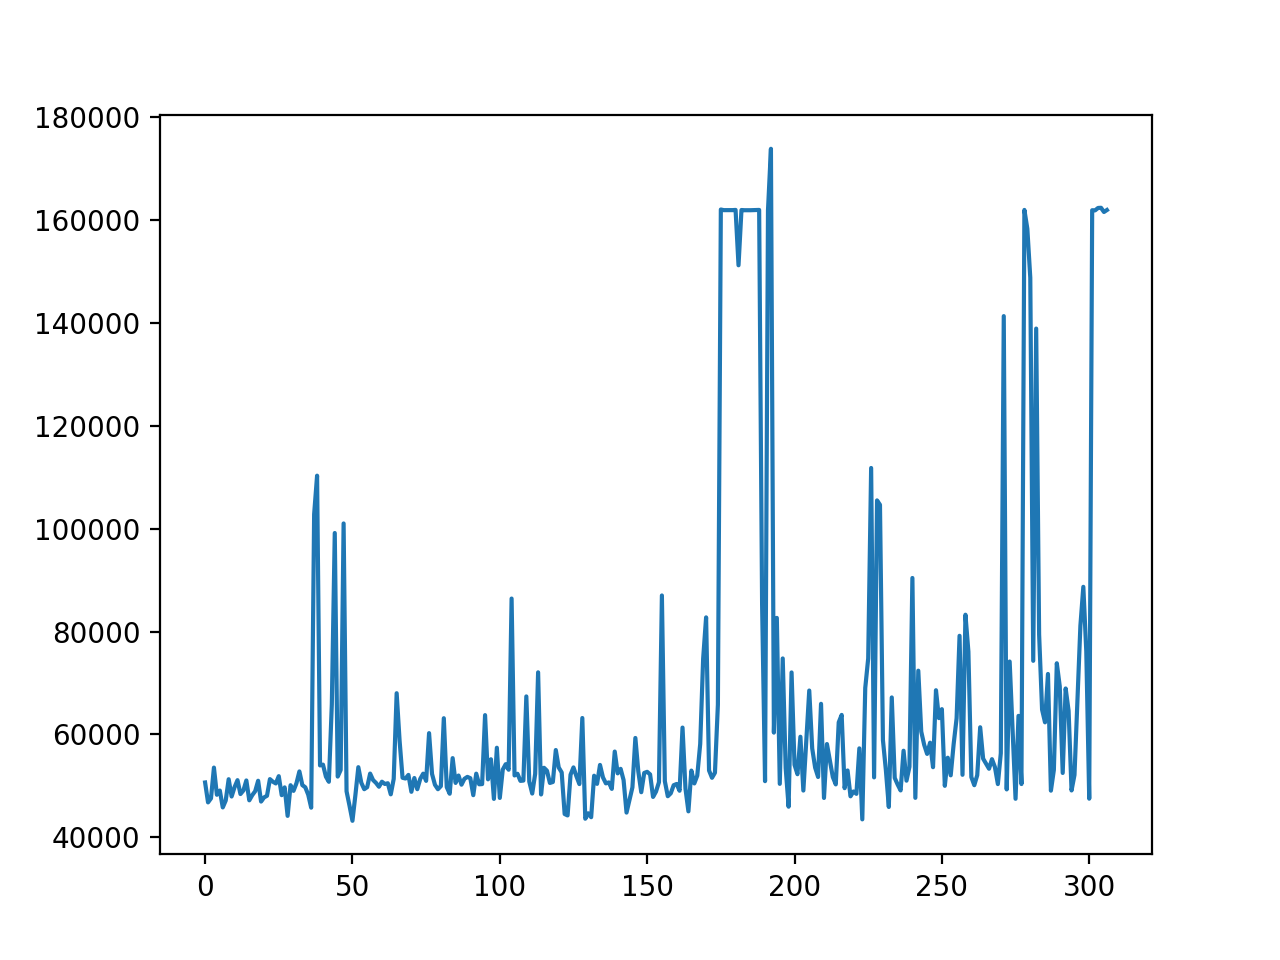

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [166]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.selected_trials_df)

<IPython.core.display.Javascript object>


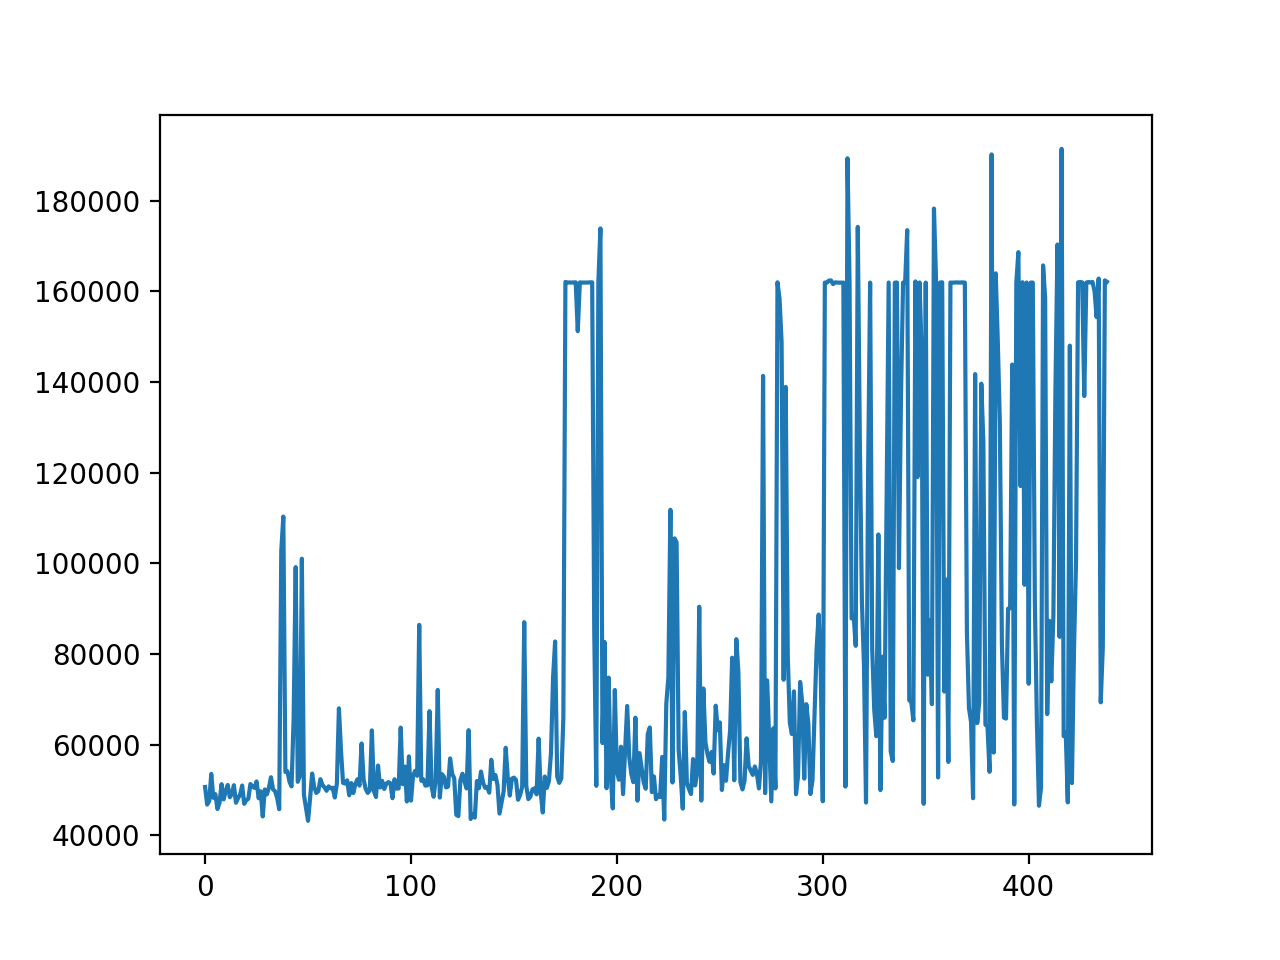

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [164]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.good_trials_df)

<IPython.core.display.Javascript object>


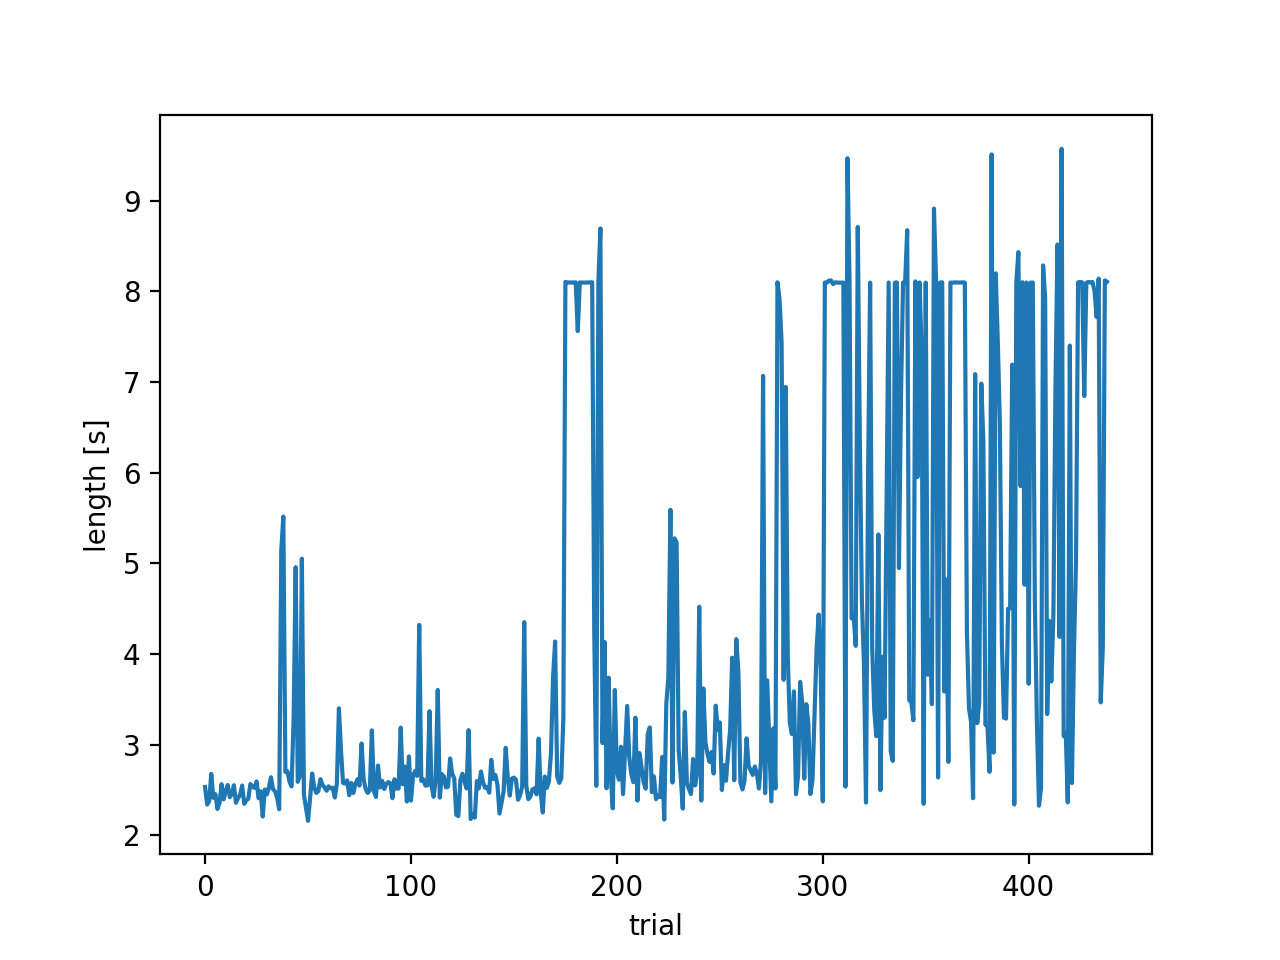

Text(0, 0.5, 'length [s]')

In [212]:
trials_df=behavior_obj.good_trials_df

fig, ax = plt.subplots()
ax.plot(trials_df['length'])
ylabels=ax.get_yticklabels()
#labels=[item.get_text() for item in ylabels]
ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set_xlabel("trial")
ax.set_ylabel("length [s]")


In [210]:
label=[item.get_text() for item in ylabels]
label
#label_new = np.array(labels).astype(int)

['20000',
 '40000',
 '60000',
 '80000',
 '100000',
 '120000',
 '140000',
 '160000',
 '180000',
 '200000']

In [194]:
new_labels=[item.get_text() for item in labels]
new_labels

['−100', '0', '100', '200', '300', '400', '500']

In [195]:
np.array(new_labels).astype(int)

ValueError: invalid literal for int() with base 10: '−100'

In [ ]:
/20000).astype(int).astype(str)

<IPython.core.display.Javascript object>


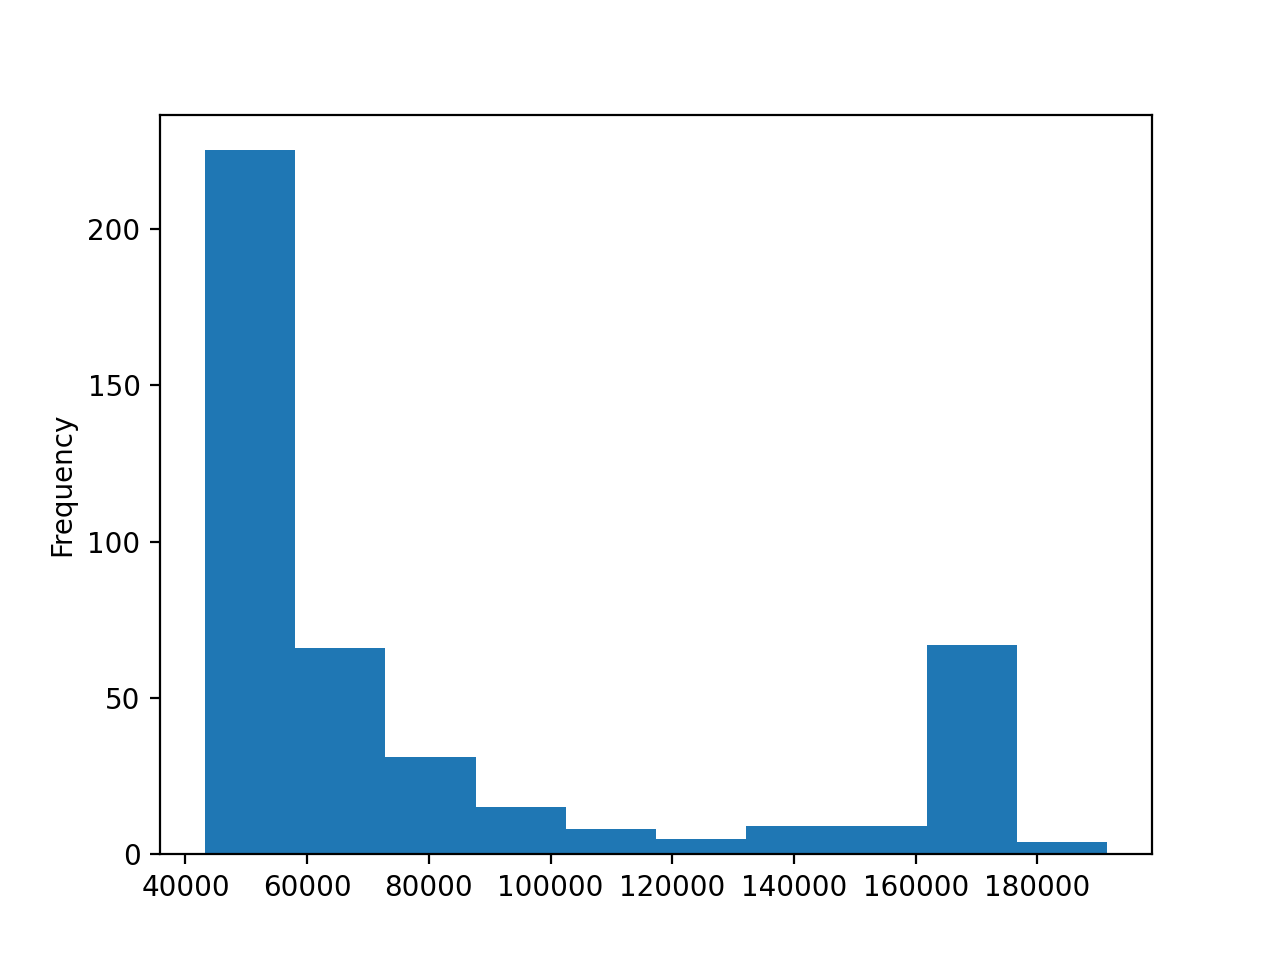

<AxesSubplot:ylabel='Frequency'>

In [173]:
fig=plt.figure()
behavior_obj.good_trials_df['length'].plot.hist()

In [177]:
qgrid.show_grid(behavior_obj.good_trials_df.sort_values("length",ascending=False))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [170]:
behavior_obj.good_trials_df[behavior_obj.good_trials_df['event']=='no response in time'].shape[0]

58

<IPython.core.display.Javascript object>


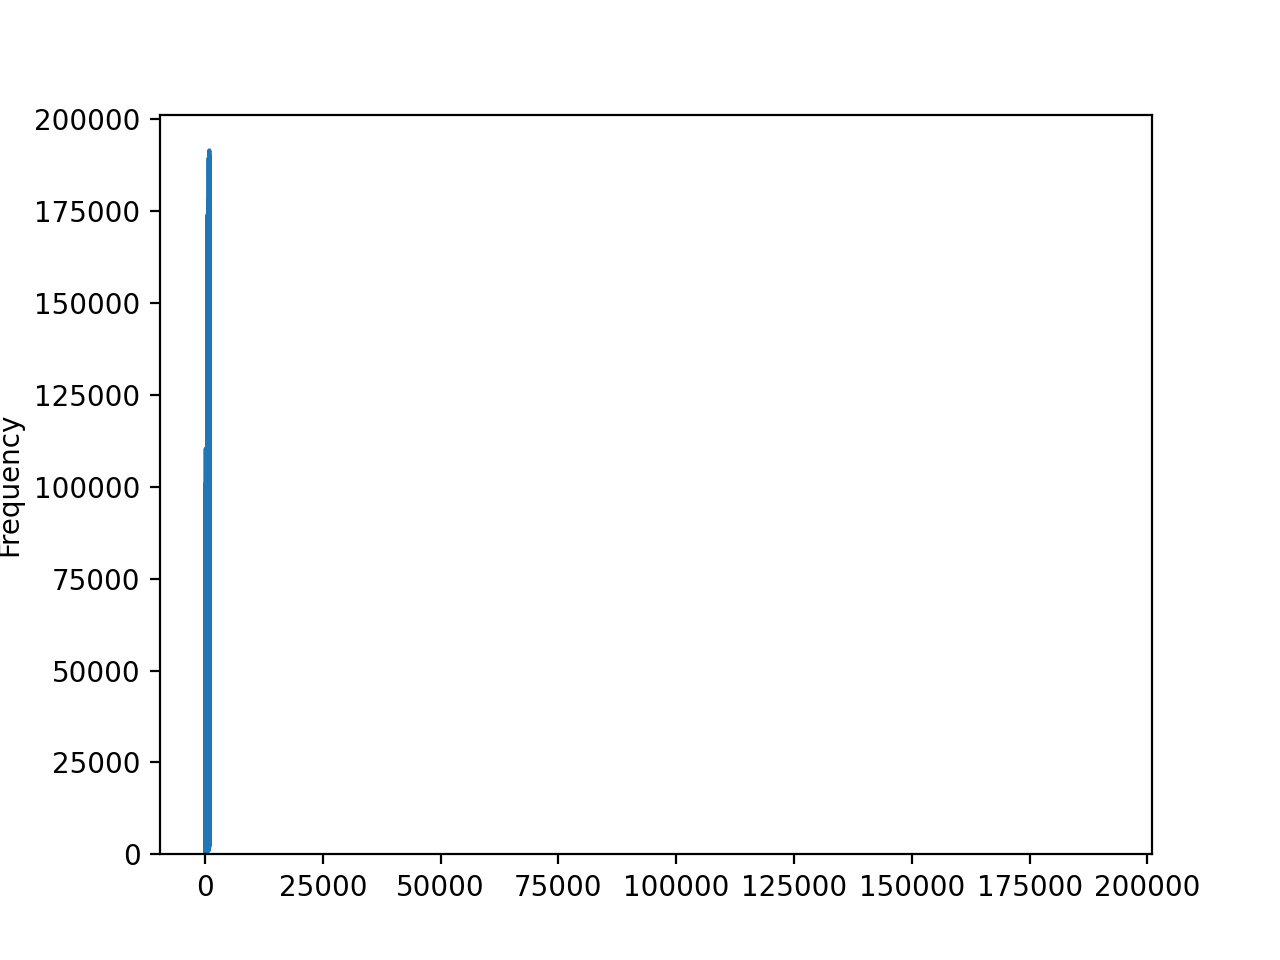

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [167]:
%matplotlib notebook
behavior_obj.plt_trial_length(behavior_obj.all_trials_df)

In [ ]:
#spikes.trials_df.loc[np.r_[0:6, 215:], 'select']
# start
JG15_190722.behavior.seleted_trials_df.loc[0:1, 'select'] = False
# end
JG15_190722.behavior.selected_trials_df.loc[215:, 'select'] = False
JG15_190722.behavior.selected_trials_df

In [ ]:
JG15_190722.eda.plt_trial_hist_and_fit(
    JG15_190722.eda.trials_df.loc[JG14_190619.eda.trials_df.loc[:, 'select'], 'length'])

In [ ]:
deselect_trials = [(X,X),(X,'end')]

---

**EDA**

---

**SDA**

---

## JG14_190621

In [2]:
%%time

session = 'JG14_190621'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = [1900,1931,1996,2058,2127]
# behavior
deselect_trials = [(0,6),(215,'end')]
# sda
window = 2000
iterations = 1000
bins = 50

sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
eda_obj = SpikesEDA(behavior_obj)
sda_obj = SpikesSDA(eda_obj)
report_obj = SpikesReport(eda_obj)

JG14_190621 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })


CPU times: user 39.4 s, sys: 856 ms, total: 40.3 s
Wall time: 40.5 s


In [ ]:
%%time
%matplotlib agg
JG14_190621.eda.generate_plots()

In [4]:
%%time
%matplotlib agg
JG14_190621.sda.generate_plots(window,iterations,bins,individual=False,reload_data_dict=True,reload_spikes_ar=False)

not intial bootstrap -> load it
no data dict -> load it
all mean vs 90per -> significant neurons
rw mean vs 90per -> significant neurons
norw mean vs 90per -> significant neurons
gamble mean vs 90per -> significant neurons
safe mean vs 90per -> significant neurons
rw_gamble mean vs 90per -> significant neurons
norw_gamble mean vs 90per -> significant neurons
rw_safe mean vs 90per -> significant neurons
norw_safe mean vs 90per -> significant neurons
block1_all mean vs 90per -> significant neurons
block1_rw mean vs 90per -> significant neurons
block1_norw mean vs 90per -> significant neurons
block1_gamble mean vs 90per -> significant neurons
block1_rw_gamble mean vs 90per -> significant neurons
block1_norw_gamble mean vs 90per -> significant neurons
block1_safe mean vs 90per -> significant neurons
block1_rw_safe mean vs 90per -> significant neurons
block1_norw_safe mean vs 90per -> significant neurons
block2_all mean vs 90per -> significant neurons
block2_rw mean vs 90per -> significant 

In [8]:
JG14_190621.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG14_190621,167,92,61,14,570,267,208,0.75,0.25,...,10,"[16, 18, 19, 21, 36, 38, 39, 41, 45, 71]",1,[16],0,[],0,[],1,[16]


In [ ]:
%%time
JG14_190621.report.generate_report()

In [11]:
del JG14_190621

## JG18b_190828

In [4]:
%%time

session = 'JG18b_190828'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = [1744, 2363, 2648, 2701, 2731, 2778,2953,2967]
# behavior
deselect_trials = [(0,0),(204,'end')]
# eda
skip_clusters = [116, 280]
# sda
window = 2000
iterations = 1000
bins = 50

sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
eda_obj = SpikesEDA(behavior_obj)
#sda_obj = SpikesSDA(eda_obj)
#report_obj = SpikesReport(eda_obj)

JG18b_190828 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    #'sda': sda_obj,
                    #'report': report_obj,
                   })



CPU times: user 1min 25s, sys: 1.36 s, total: 1min 26s
Wall time: 1min 27s


In [ ]:
%%time
%matplotlib agg
JG18b_190828.eda.generate_plots(window,bins)

cue aligned - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike trains + histogram -> all
reward algined - spike 

TypeError: 'Figure' object is not subscriptable

In [7]:
%%time
%matplotlib agg
JG18b_190828.sda.generate_plots(window,iterations,bins,individual=False,load=False)

all mean vs 2sigma -> significant neurons
rw mean vs 2sigma -> significant neurons
norw mean vs 2sigma -> significant neurons
gamble mean vs 2sigma -> significant neurons
safe mean vs 2sigma -> significant neurons
rw_gamble mean vs 2sigma -> significant neurons
norw_gamble mean vs 2sigma -> significant neurons
rw_safe mean vs 2sigma -> significant neurons
norw_safe mean vs 2sigma -> significant neurons
block1_all mean vs 2sigma -> significant neurons
block1_rw mean vs 2sigma -> significant neurons
block1_norw mean vs 2sigma -> significant neurons
block1_gamble mean vs 2sigma -> significant neurons
block1_rw_gamble mean vs 2sigma -> significant neurons
block1_norw_gamble mean vs 2sigma -> significant neurons
block1_safe mean vs 2sigma -> significant neurons
block1_rw_safe mean vs 2sigma -> significant neurons
block1_norw_safe mean vs 2sigma -> significant neurons
block2_all mean vs 2sigma -> significant neurons
block2_rw mean vs 2sigma -> significant neurons
block2_norw mean vs 2sigma -

In [8]:
JG18b_190828.sda.info_df

,session,tot. clusters,nr. good,nr. mua,nr. noise,tot. trials,good trials,selected trials,rw block 1,rw block 2,...,3 rw_safe all,3 rw_safe all neurons,3 norw_safe before,3 norw_safe before neurons,3 norw_safe across,3 norw_safe across neurons,3 norw_safe after,3 norw_safe after neurons,3 norw_safe all,3 norw_safe all neurons
1,JG18b_190828,385,187,174,24,727,375,203,0.75,0.25,...,18,"[48, 52, 53, 60, 61, 64, 66, 67, 86, 96, 97, 1...",0,[],0,[],0,[],0,[]


In [ ]:
%%time
#%matplotlib agg
JG18b_190828.report.generate_report()

In [9]:
JG18b_190828.eda.gamble_side

'right'

# Workbench

In [8]:
JG14_190621.behavior.selected_trials_df.shape[0]

208

In [7]:
JG18b_190828.behavior.selected_trials_df.shape[0]

203